In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import absolute
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [2]:
df = pd.read_csv(r"D:/instagram_reach.csv")

In [3]:
df.head()

,Unnamed: 0,S.No,USERNAME,Caption,Followers,Hashtags,Time since posted,Likes
0,0,1,mikequindazzi,Who are #DataScientist and what do they do? >>...,1600,#MachineLearning #AI #DataAnalytics #DataScien...,11 hours,139
1,1,2,drgorillapaints,We all know where it’s going. We just have to ...,880,#deck .#mac #macintosh#sayhello #apple #steve...,2 hours,23
2,2,3,aitrading_official,Alexander Barinov: 4 years as CFO in multinati...,255,#whoiswho #aitrading #ai #aitradingteam#instat...,2 hours,25
3,3,4,opensourcedworkplace,sfad,340,#iot #cre#workplace #CDO #bigdata #technology#...,3 hours,49
4,4,5,crea.vision,Ever missed a call while your phone was chargi...,304,#instamachinelearning #instabigdata#instamarke...,3 hours,30


In [4]:
df.columns

Index(['Unnamed: 0', 'S.No', 'USERNAME', 'Caption', 'Followers', 'Hashtags',
       'Time since posted', 'Likes'],
      dtype='object')

In [5]:
df.drop(columns=['Unnamed: 0', 'S.No'],axis=1,inplace=True)

In [6]:
df.head()

,USERNAME,Caption,Followers,Hashtags,Time since posted,Likes
0,mikequindazzi,Who are #DataScientist and what do they do? >>...,1600,#MachineLearning #AI #DataAnalytics #DataScien...,11 hours,139
1,drgorillapaints,We all know where it’s going. We just have to ...,880,#deck .#mac #macintosh#sayhello #apple #steve...,2 hours,23
2,aitrading_official,Alexander Barinov: 4 years as CFO in multinati...,255,#whoiswho #aitrading #ai #aitradingteam#instat...,2 hours,25
3,opensourcedworkplace,sfad,340,#iot #cre#workplace #CDO #bigdata #technology#...,3 hours,49
4,crea.vision,Ever missed a call while your phone was chargi...,304,#instamachinelearning #instabigdata#instamarke...,3 hours,30


In [7]:
df.dtypes

USERNAME             object
Caption              object
Followers             int64
Hashtags             object
Time since posted    object
Likes                 int64
dtype: object

### Check null values

In [8]:
df.isna().sum()

USERNAME             0
Caption              6
Followers            0
Hashtags             0
Time since posted    0
Likes                0
dtype: int64

### There are 6 null values in Caption, that are samll if we drop it then it will not impact on the data, so let's drop it.

In [9]:
df.dropna(inplace=True)

In [10]:
df['Caption'] = [str(caption) for caption in df['Caption']]

In [11]:
df['Hashtags'] = [str(Hashtag) for Hashtag in df['Hashtags']]

### The time column must be in float or int formate lets convert it.

In [12]:
df['Time since posted'] = [int(float(hour.replace(" ","").rstrip("hours"))) for hour in df['Time since posted']]

### Let's check the distributions.

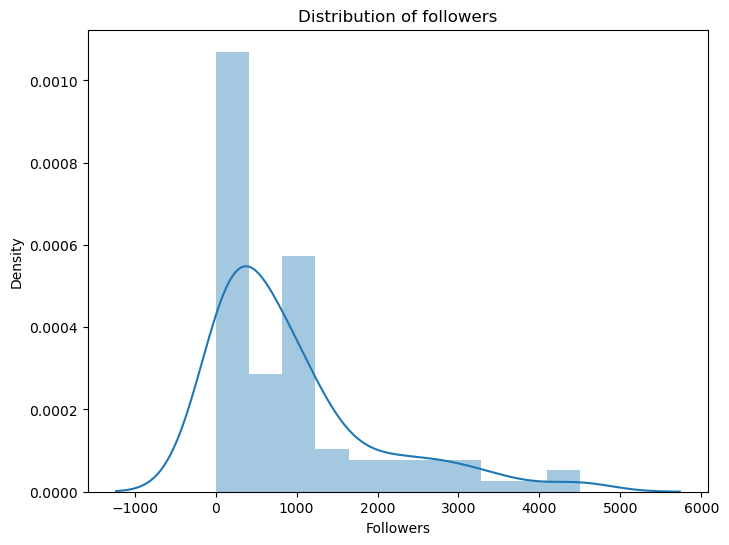

In [13]:
plt.figure(figsize=(8,6))
sns.distplot(df["Followers"])
plt.title("Distribution of followers")
plt.show()

#### The Followers distribution is right skewed.

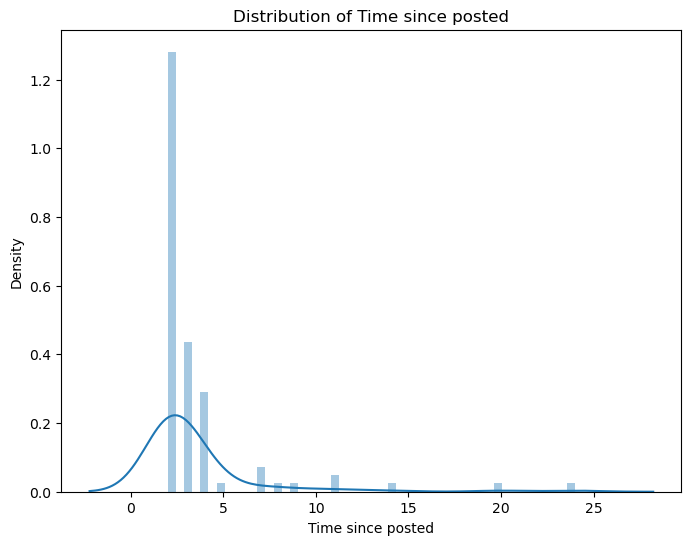

In [14]:
plt.figure(figsize=(8,6))
sns.distplot(df["Time since posted"])
plt.title("Distribution of Time since posted")
plt.show()

#### The distribution of Time Since posted is also right skewed.

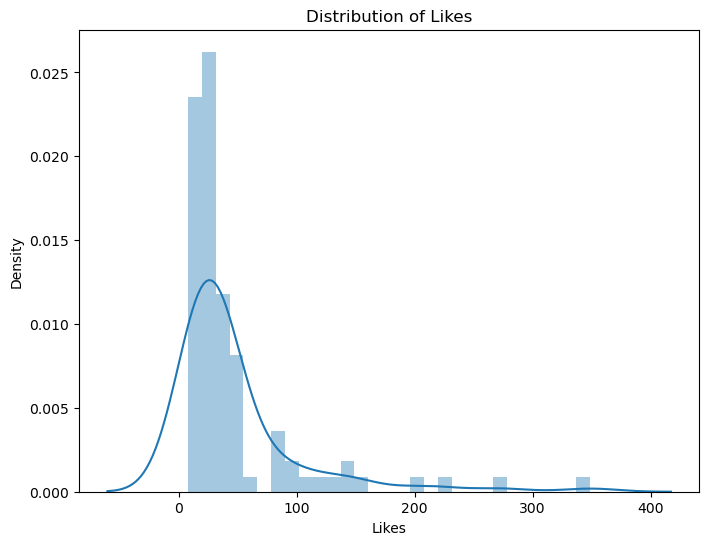

In [15]:
plt.figure(figsize=(8,6))
sns.distplot(df["Likes"])
plt.title("Distribution of Likes")
plt.show()

#### The distribution of Like varibale is right skewed.

## To know which word is used mostly we can use wordcloud to analysing the variables caption and Hashtags.

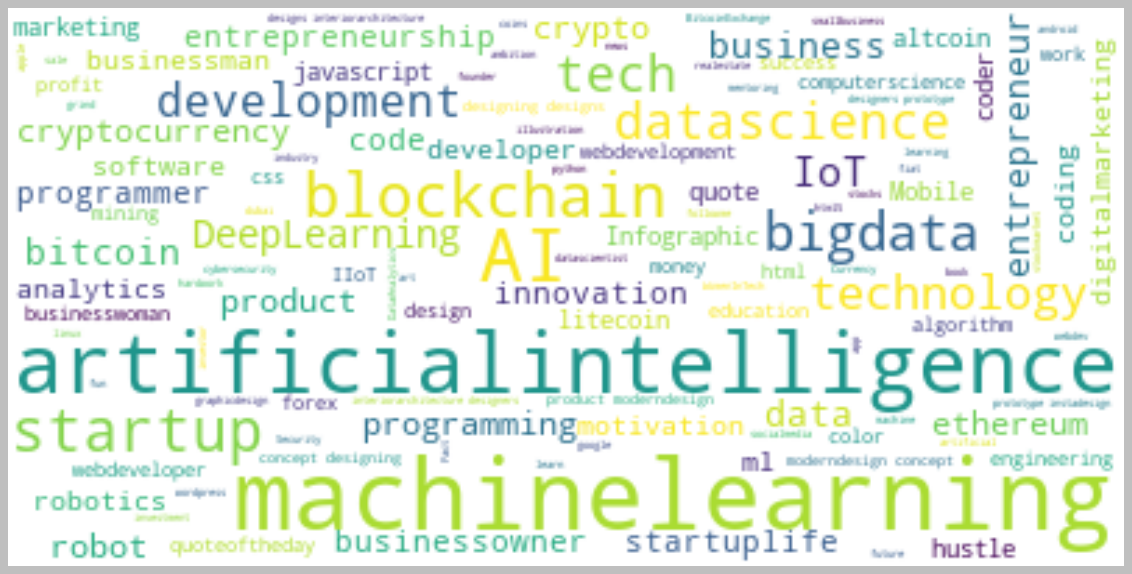

In [16]:
text = " ".join(i for i in df.Hashtags)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.style.use('classic')
plt.figure( figsize=(18,16))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### From word cloud above we know that words like 'artificialintelligence', 'machinelearning', 'AI' are the top three words on Hashtag.

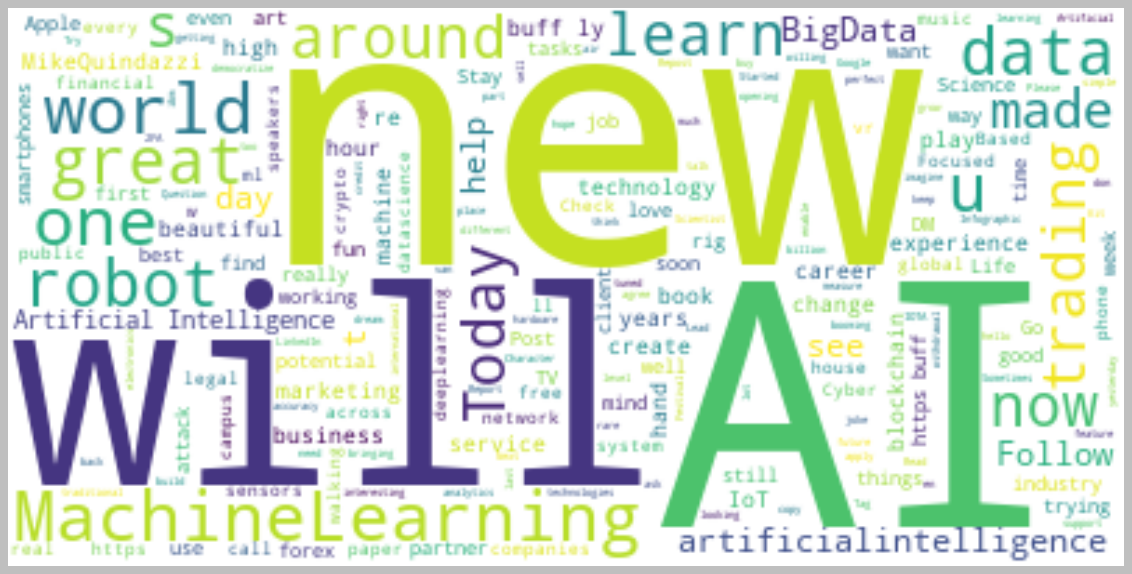

In [17]:
text = " ".join(i for i in df.Caption)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.style.use('classic')
plt.figure( figsize=(18,16))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Let's check the correlation.

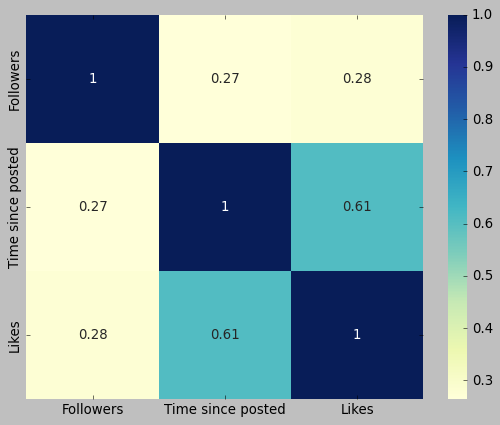

In [18]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
plt.show()

#### There is strong correlation between Time since posted and Likes.

In [50]:
# Let's define numerical and categorical columns.
numeric_col = [col for col in df.columns if df[col].dtype != 'O']
categorical_col = [col for col in df.columns if df[col].dtype == 'O']
categorical_col = categorical_col[1:]

In [51]:
print(numeric_col)
print(categorical_col)

['Followers', 'Time since posted', 'Likes']
['Caption', 'Hashtags']


# Create function for model training and evaluation.

In [21]:
def eveluate_reg(true,predicted):
    '''
    This function takes in true values and predicted values
    Returns: MSE, MAE, r2_score (R^2-adjusted), RMSE
    '''
    
    MSE = mean_squared_error(true,predicted) #Calculate mean squared error.
    RMSE = mean_squared_error(true,predicted,squared=False) # Calculate root mean squared error.
    MAE = mean_absolute_error(true,predicted) # Calculate mean absolute error.
    r2 = r2_score(true,predicted) # R-squared adjusted.
    return MSE,RMSE,MAE,r2

### Splitting the dataframe into dependent and independent variables.

In [22]:
X = df.drop(columns=['USERNAME', 'Caption','Hashtags','Likes'],axis=1)

In [23]:
y = df.Likes

### Splitting the data into train and test part.

In [24]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

## Linear Regression model

In [25]:
LR_model = LinearRegression()

In [26]:
LR_model.fit(X_train,y_train)

LinearRegression()

In [27]:
y_pred = LR_model.predict(X_test)

In [28]:
eveluate_reg(y_test,y_pred)

(725.3192385309767, 26.931751493933266, 20.341529910256806, 0.545586646136722)

## Decision Tree Model

In [29]:
DT_model = DecisionTreeRegressor()

In [30]:
DT_model.fit(X_train,y_train)

DecisionTreeRegressor()

In [31]:
y_pred_DT = DT_model.predict(X_test)

In [32]:
eveluate_reg(y_test,y_pred_DT)

(1703.2105263157894,
 41.26997124200342,
 24.36842105263158,
 -0.06706339289433116)

## SVR Model

In [33]:
svr_model = SVR()

In [34]:
svr_model.fit(X_train,y_train)

SVR()

In [35]:
y_pred_svr = svr_model.predict(X_test)

In [36]:
eveluate_reg(y_test,y_pred_svr)

(1703.903431567463,
 41.278365175567004,
 24.927508401346884,
 -0.06749749884740108)

## Random Forest Model

In [37]:
RF_model = RandomForestRegressor()

In [38]:
RF_model.fit(X_train,y_train)

RandomForestRegressor()

In [39]:
y_pred_RF = RF_model.predict(X_test)

In [40]:
eveluate_reg(y_test,y_pred_RF)

(860.0908210526318,
 29.327305042445204,
 18.194736842105264,
 0.46115209157676973)

## XGB Model

In [41]:
XGB_model = XGBRegressor()

In [42]:
XGB_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [43]:
y_pred_XGB = XGB_model.predict(X_test)

In [44]:
eveluate_reg(y_test,y_pred_XGB)

(939.7316390847074,
 30.655042637137324,
 18.363737959610788,
 0.41125702564736255)

## CatBoost Model

In [45]:
catboost_model = CatBoostRegressor()

In [54]:
catboost_model.fit(X_train,y_train)

Learning rate set to 0.027192
0:	learn: 59.2686253	total: 689us	remaining: 689ms
1:	learn: 59.0416639	total: 1.24ms	remaining: 618ms
2:	learn: 58.9007906	total: 1.46ms	remaining: 484ms
3:	learn: 58.7111313	total: 2.12ms	remaining: 529ms
4:	learn: 58.5070008	total: 2.78ms	remaining: 553ms
5:	learn: 58.2710456	total: 3.26ms	remaining: 540ms
6:	learn: 58.1370491	total: 3.47ms	remaining: 493ms
7:	learn: 57.9408452	total: 4.14ms	remaining: 514ms
8:	learn: 57.7579063	total: 4.63ms	remaining: 510ms
9:	learn: 57.5516604	total: 5.38ms	remaining: 533ms
10:	learn: 57.2562284	total: 6.08ms	remaining: 547ms
11:	learn: 57.0439829	total: 6.73ms	remaining: 554ms
12:	learn: 56.8547374	total: 7.32ms	remaining: 556ms
13:	learn: 56.5822389	total: 7.93ms	remaining: 559ms
14:	learn: 56.3741258	total: 8.53ms	remaining: 560ms
15:	learn: 56.1337262	total: 9.16ms	remaining: 563ms
16:	learn: 55.8778883	total: 9.82ms	remaining: 568ms
17:	learn: 55.6731068	total: 10.1ms	remaining: 553ms
18:	learn: 55.4751531	total

In [55]:
y_pred_catboost = catboost_model.predict(X_test)

In [56]:
eveluate_reg(y_test,y_pred_catboost)

(917.7180565487209, 30.293861697524154, 16.820557050402744, 0.4250485609318585)

## Here the linear Regression model is good which explaining 54.55% variation about likes.